In [2]:
import sys
sys.path.append('../')
import torch 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.dataset import Segmentation_CustomDataset as CustomDataset
import os
import torch.optim as optim
from utils.__init__ import *
from utils import custom_transforms
from utils import * 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys 
sys.path.append('../')
from model import load_model

2024-05-19 04:12:39.756743: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 04:12:39.785277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 04:12:40.196228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


torch.Size([32, 1, 224, 224]) torch.Size([32, 1, 224, 224])
image range : -1.0~1.0
mask range : 0.0~1.0


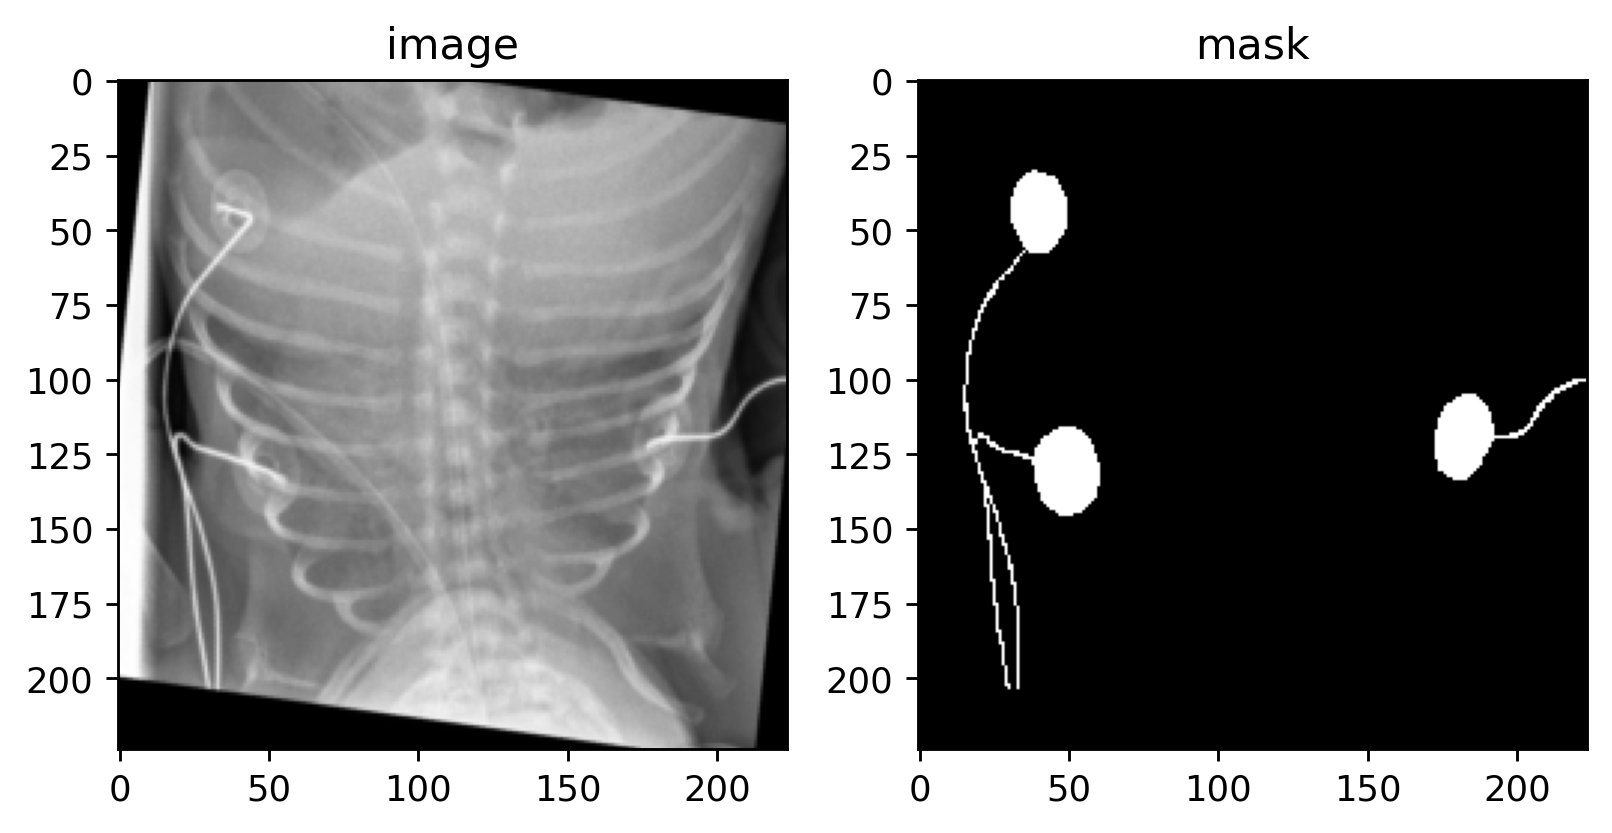

torch.Size([32, 1, 224, 224]) torch.Size([32, 1, 224, 224])
image range : -1.0~0.9921568632125854
mask range : 0.0~1.0


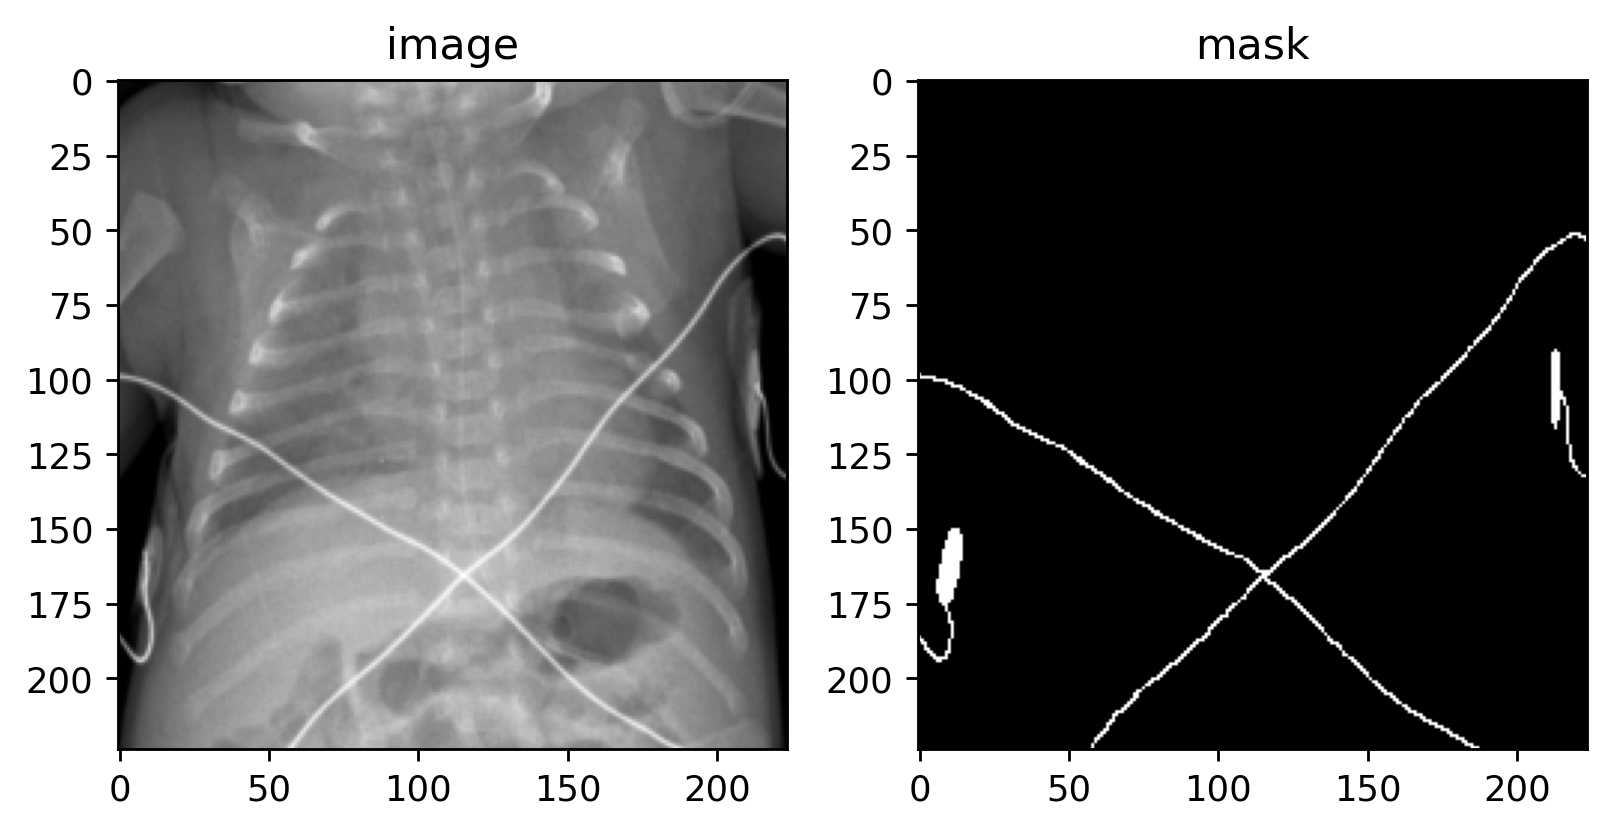

In [3]:
tr_img_dir = '/mnt/HDD/chest-seg/dataset/train_img'
tr_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 
vl_img_dir = '/mnt/HDD/chest-seg/dataset/train_img' 
vl_mask_dir = '/mnt/HDD/chest-seg/dataset/train_mask' 
    
transform = {
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
}

# Dataset and DataLoader setup
train_dataset = CustomDataset(
    image_dir = tr_img_dir,
    mask_dir = tr_mask_dir,
    transform=transform['train'],
    testing=False,
)

valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform=transform['valid'],
    testing=True,  # Disables random transformations for validation
)
tr_batch, vl_batch = 32, 32
train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = True)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    print(f'image range : {images.unique()[0]}~{images.unique()[-1]}')
    print(f'mask range : {masks.unique()[0]}~{masks.unique()[-1]}')
    train_plotting(images, masks)
    break

for images, masks, paths in valid_loader:
    print(images.shape, masks.shape)
    print(f'image range : {images.unique()[0]}~{images.unique()[-1]}')
    print(f'mask range : {masks.unique()[0]}~{masks.unique()[-1]}')
    train_plotting(images, masks)
    break


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

model_name = 'monai_swinunet'

save_path = os.path.join('/mnt/HDD/chest-seg_models', model_name+ '_debug')
os.makedirs(save_path, exist_ok=True)

model_loader = load_model.segmentation_models_loader(model_name = model_name)
model = model_loader().to(device)
            
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss().to(device)
metrics = {
    'train_loss':[], 'train_acc':[], 'train_iou':[], 
    'valid_loss':[], 'valid_acc':[], 'valid_iou':[],
}

print(f'output shape : {model(torch.randn(tr_batch, 1, 224, 224).to(device)).shape}')

Model: MONAI-SwinUNET loaded successfully!! | pretrained : brain MRI
output shape : torch.Size([32, 1, 224, 224])


In [5]:

from utils.metrics import calculate_metrics
for epoch in range(500):
    train_losses, train_accs, train_ious, valid_losses, valid_accs, valid_ious = 0, 0, 0, 0, 0, 0
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # BCE Logistic Loss
        loss = loss_fn(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses += loss.cpu().detach().item()
        
        preds = torch.sigmoid(outputs)
        acc, iou, dice, hd = calculate_metrics(preds, masks, 0.5)
        print(acc,iou,dice,hd)
        
        train_accs += acc
        train_ious += iou

    with torch.no_grad():
        model.eval()
        for images, masks, paths in valid_loader:
            images, masks = images.to(device), masks.to(device)
            ### inference
            outputs = model(images)  # 3+1ch

            loss = loss_fn(outputs, masks)
            print(loss.cpu().detach().item())
            valid_losses += loss.cpu().detach().item()
            
            preds = torch.sigmoid(outputs)
            print(print(f"output range : {preds.min()} ~ {preds.max()}"))
            acc, iou = calculate_metrics(preds, masks, 0.5)
            valid_accs += acc
            valid_ious += iou
            
    if epoch % 5 == 0:
        save_validation(images, masks, (torch.sigmoid(outputs)>0.5).int(), epoch, save_dir = save_path)
    #     save_model(model, optimizer, epoch, save_dir = save_path)
    #     save_loss(metrics, save_dir = save_path)

    metrics['train_loss'].append(train_losses / len(train_loader))
    metrics['train_acc'].append(train_accs / len(train_loader))
    metrics['train_iou'].append(train_ious / len(train_loader))
    metrics['valid_loss'].append(valid_losses / len(valid_loader))
    metrics['valid_acc'].append(valid_accs / len(valid_loader))
    metrics['valid_iou'].append(valid_ious / len(valid_loader))

    print("#" * 100)    
    print(f"Train - BCE : {metrics['train_loss'][-1]} | ACC : {metrics['train_acc'][-1]} | mIoU : {metrics['train_iou'][-1]} | ")
    print(f"Valid - BCE : {metrics['valid_loss'][-1]} | ACC : {metrics['valid_acc'][-1]} | mIoU : {metrics['valid_iou'][-1]} | ")
    print("#" * 100)
    


0.014091623947024345 0.5515902638435364 0.027581922709941864 14.7648230602334
0.014084483496844769 0.5676680207252502 0.027595609426498413 14.594519519326424
0.016718020662665367 0.6180064678192139 0.03262785077095032 14.560219778561036
0.019302314147353172 0.6663201451301575 0.037625353783369064 14.594519519326424
0.024540601298213005 0.7360652685165405 0.047498397529125214 14.730919862656235
0.029588406905531883 0.788595974445343 0.057014577090740204 14.66287829861518
0.0321492999792099 0.8189423084259033 0.06194797158241272 14.45683229480096
0.03253961727023125 0.8464480042457581 0.06264045834541321 14.66287829861518
0.03822658210992813 0.8593862056732178 0.07304450869560242 14.594519519326424
0.0402865931391716 0.8746399879455566 0.07699619233608246 14.594519519326424
0.04808796942234039 0.8850309252738953 0.09105686843395233 14.45683229480096
0.04858878254890442 0.8969851136207581 0.0919012725353241 14.696938456699069
0.05389241874217987 0.9080935120582581 0.10149539262056351 14.4

KeyboardInterrupt: 

In [5]:
# weight 확인
for name, param in model.named_parameters():
    print(name, param.shape)
    print(param)
    break

# weight 저장
torch.save(model.state_dict(), os.path.join(save_path, 'model.pth'))

swinViT.patch_embed.proj.weight torch.Size([24, 1, 2, 2])
Parameter containing:
tensor([[[[-4.6468e-01,  1.1543e-01],
          [ 3.6282e-01,  3.5261e-01]]],


        [[[-1.2256e-01,  3.8729e-01],
          [-2.5641e-01,  2.7257e-01]]],


        [[[-2.2296e-01, -9.0898e-02],
          [-3.0433e-01,  8.3907e-02]]],


        [[[ 3.5192e-01,  8.6060e-02],
          [-4.7344e-02,  1.5747e-02]]],


        [[[ 1.9883e-01,  2.0612e-01],
          [-2.1662e-01,  4.5335e-01]]],


        [[[ 3.3858e-01,  7.3590e-03],
          [-2.1900e-01,  4.6192e-01]]],


        [[[-3.2067e-01, -2.2234e-02],
          [-8.0196e-02,  3.3881e-01]]],


        [[[-2.7918e-01,  7.8045e-02],
          [-2.3430e-01, -3.4702e-01]]],


        [[[ 2.5911e-01, -1.7168e-01],
          [-7.3853e-04,  2.9660e-01]]],


        [[[-8.7839e-03, -4.3904e-01],
          [ 2.8434e-01,  2.0487e-01]]],


        [[[-4.6326e-01,  2.0021e-01],
          [ 4.2590e-01, -2.3823e-02]]],


        [[[-2.1658e-01,  2.1904e-01],
  